In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1
USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = True#(ON_KAGGLE and SAMPLE_LEVEL == 0)

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
# THIS CELL WILL BE REMOVE WITH SCRIPTS IN SRC
if './src/' not in sys.path:
    sys.path.append('./src/')

from preprocessing import *
from metrics import *
from cv import *
from modeling import *
from tracking import track_experiment
import util

In [7]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [8]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING SAMPLE DATASET


In [9]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 5.71 s, sys: 719 ms, total: 6.43 s
Wall time: 6.43 s


In [11]:
raw_df = ingest_data(raw_df, asset_details_path=ASSET_DETAILS_PATH)

In [12]:
raw_df.sort_values(by=['Asset_ID', 'time'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [13]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,time
0,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2749.5692,37.387058,-0.001669,Binance Coin,2021-01-01 00:01:00
1,1609459320,0,133.0,37.390499,37.402000,37.329800,37.331299,778.8680,37.351677,-0.001542,Binance Coin,2021-01-01 00:02:00
2,1609459380,0,151.0,37.317051,37.336700,37.272900,37.291500,890.9210,37.301258,-0.001028,Binance Coin,2021-01-01 00:03:00
3,1609459440,0,123.0,37.299149,37.323002,37.250198,37.291901,489.9361,37.297272,0.000174,Binance Coin,2021-01-01 00:04:00
4,1609459500,0,623.0,37.212799,37.285000,37.104801,37.213001,15144.3836,37.184082,0.000950,Binance Coin,2021-01-01 00:05:00


In [14]:
TARGET = 'Target'
INDEX_COLS = ['Asset_ID', 'Asset_Name', 'date', 'timestamp']

In [15]:
RAW_FEATURES = ['Count', 'Open', 'High', 'Low', 'Close',
                'Volume', 'VWAP']

In [16]:
crypto_data = raw_df.query("Asset_Name == 'Binance Coin'")

In [17]:
def create_valid_date_range(data: pd.DataFrame, dt_col: str = 'time'):
    first_date, end_date = data[dt_col].agg(('min', 'max'))
    date_range = pd.date_range(first_date, end_date, freq='min')
    return date_range
    
def fill_gaps(data: pd.DataFrame, dt_col: str = 'time'):
    valid_date_range = create_valid_date_range(data, dt_col)
    data = data.set_index(dt_col)
    filled_data = data.reindex(valid_date_range)
    return filled_data.reset_index().rename(columns={'index': dt_col})

In [18]:
data = fill_gaps(crypto_data)

In [19]:
TARGET = 'Target'

In [20]:
# fillnan with 0
data[TARGET] = data[TARGET].fillna(0)

data.fillna({f: 0 for f in RAW_FEATURES}, inplace=True)

In [21]:
PULIC_LB_RANGE = ['2021-06-13 00:00:00',
                  '2021-09-13 00:00:00'] # 3 MONTH WORTH OF DATA

if USE_TOY_SAMPLE:
    EVAL_PERIODS = [['2021-09-15', '2021-09-22']]

elif USE_SAMPLE:
    EVAL_PERIODS = [PULIC_LB_RANGE]
    
else:
    EVAL_PERIODS = [['2019-01-01', '2019-04-01'],
                    ['2021-03-13', '2021-06-12 00:00:00'], 
                    PULIC_LB_RANGE]
    
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}

In [22]:
EVAL_PERIODS

[['2021-06-13 00:00:00', '2021-09-13 00:00:00']]

In [23]:
CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)

In [24]:
train_idx, valid_idx = next(iter(CV.split(data)))

In [25]:
train_data = data.loc[train_idx, :].reset_index(drop=True)
valid_data = data.loc[valid_idx, :].reset_index(drop=True)

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()
train_data[RAW_FEATURES] = scaler.fit_transform(train_data[RAW_FEATURES])
valid_data[RAW_FEATURES] = scaler.transform(valid_data[RAW_FEATURES])

In [28]:
from typing import Tuple, List

class TimeSeriesDataset:
    def __init__(self, features: np.ndarray,
                 target: np.ndarray,
                 lags: int = 0):
        self.features = features
        self.target = target
        self.lags = lags
    
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        assert index >= 0 and index < len(self.target), \
               f'index={index} out of range, {0}>={index}<{len(self.target)}'
        train_indices = np.arange(index - self.lags, index) + 1
        train_indices[train_indices < 0] = 0
        
        return self.features[train_indices], self.target[index]

    @classmethod
    def from_dataframe(cls, data: pd.DataFrame,
                       features: List[str],
                       target: List[str],
                       lags: int = 0):
        features_values = data.loc[:, features].to_numpy().astype(np.float32)
        target_values = data.loc[:, target].to_numpy().astype(np.float32)
        
        return cls(features_values, target_values, lags=lags)

In [29]:
ds = TimeSeriesDataset(np.arange(10), np.arange(1, 11), lags=5)

In [30]:
import torch
from torch import nn, optim


def compute_cnn_output_dim(Lin: int, C: nn.Conv1d) -> int:    
    padding = 2 * C.padding[0]
    kernel = C.dilation[0] * (C.kernel_size[0] - 1)
    Lout = (Lin + padding - kernel - 1) / C.stride[0]
    assert Lout % 1 == 0
    return int(Lout) + 1

def test_compute_cnn_output_dim():
    kernel_size = np.random.randint(10, 30)
    conv = nn.Conv1d(5, 100, kernel_size=kernel_size)
    
    for _ in range(100):
        Lin = np.random.randint(kernel_size, 100)
        x = torch.randn(64, 5, Lin)
        e = conv(x).shape[-1]
        assert e == compute_cnn_output_dim(Lin, conv)
test_compute_cnn_output_dim()

In [53]:
from functools import reduce
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm.auto import tqdm


def mspe(yhat, y):
    eps = 1e-15
    return torch.square((y-yhat)/ (y + eps)).mean()


def build_cnn_layer(input_dim: int, output_dim: int,
                    kernel_size: int = 5,
                    batch_bn: bool = False,
                    dropout: float = 0.,
                    relu: bool = False):
    output_layer = []
    layer = nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size)
    output_layer.append(layer)
    if relu:
        output_layer.append(nn.ReLU())
    if batch_bn:
        output_layer.append(nn.BatchNorm1d(output_dim))
    if dropout > 0.:
        output_layer.append(nn.Dropout(dropout))
    return nn.Sequential(*output_layer)


class LimitSigmoid(nn.Module):
    def __init__(self, lower_limit: float = 0., upper_limit: float = 1.):
        super().__init__()
        self.lower_limit = lower_limit
        self.difference = upper_limit - lower_limit
        
    def forward(self, x):
        x = torch.sigmoid(x)
        return x * self.difference + self.lower_limit
    
class ResidualLayer(nn.Module):
    def __init__(self, input_dim: int, expand_dim: int = None):
        super().__init__()
        if expand_dim is None:
            expand_dim = 2 * input_dim
        self.hidden = nn.Linear(input_dim, expand_dim)
        self.out = nn.Linear(expand_dim, input_dim)
        
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        xt = F.relu(self.hidden(x))
        return F.relu(x + self.out(xt))


class CnnModel(nn.Module):
    def __init__(self, input_dim: int,
                 lags: int,
                 output_dim: int):
        super().__init__()
        filters = [input_dim, 16, 32]
        
        self.res = ResidualLayer(input_dim)
        self.cnns = nn.Sequential(*[build_cnn_layer(input_dim, output_dim, batch_bn=False, relu=True)
                                    for input_dim, output_dim in zip(filters[:-1], filters[1:])])
        
        
        output_cnn_dim = lags // 4
        self.avg_pool = nn.AdaptiveAvgPool1d(output_cnn_dim)
        
        
        self.decoder = nn.Linear(output_cnn_dim * 32, output_dim)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        # input x shape: bs, sq, ft
        # expected bs, ft, sq
        x = self.res(x)
        x = x.transpose(2, 1)
        x = self.cnns(x)
        x = self.avg_pool(x).flatten(1)
        return self.decoder(x)

    
def train(model: nn.Module, optimizer: optim.Optimizer, train_dl: DataLoader):
    model.train()
    for i, (x, y) in enumerate(train_dl):
        # zero all gradients
        optimizer.zero_grad()
        # forward pass
        yhat = model(x)
        # loss
        loss = F.mse_loss(yhat, y)
        # backward pass
        loss.backward()
        # update params
        optimizer.step()
        if i % 100 == 0:
            print(f'iter {i}, loss={loss.item()}')

In [54]:
LAGS = 60
BATCH_SIZE=512

In [55]:
train_ds = TimeSeriesDataset.from_dataframe(train_data, features=RAW_FEATURES,
                                            target=[TARGET], lags=LAGS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [56]:
valid_ds = TimeSeriesDataset.from_dataframe(valid_data, features=RAW_FEATURES,
                                            target=[TARGET], lags=LAGS)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [57]:
model = CnnModel(len(RAW_FEATURES), LAGS, output_dim=1)
opt = optim.Adam(model.parameters(), lr=0.001)

In [58]:
model

CnnModel(
  (res): ResidualLayer(
    (hidden): Linear(in_features=7, out_features=14, bias=True)
    (out): Linear(in_features=14, out_features=7, bias=True)
  )
  (cnns): Sequential(
    (0): Sequential(
      (0): Conv1d(7, 16, kernel_size=(5,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
      (1): ReLU()
    )
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=15)
  (decoder): Linear(in_features=480, out_features=1, bias=True)
)

In [59]:
for e in range(30):
    train(model, opt, train_dl)

iter 0, loss=0.0024519674479961395
iter 100, loss=3.398732951609418e-05
iter 200, loss=2.4993318220367655e-05
iter 300, loss=3.4791675716405734e-05
iter 400, loss=3.836369069176726e-05
iter 0, loss=3.0219052860047668e-05
iter 100, loss=2.966702959383838e-05
iter 200, loss=3.0216024242690764e-05
iter 300, loss=3.641254443209618e-05
iter 400, loss=2.7173869966645725e-05
iter 0, loss=2.9454848117893562e-05
iter 100, loss=3.5533470509108156e-05
iter 200, loss=3.913282853318378e-05
iter 300, loss=2.951269198092632e-05
iter 400, loss=4.292626545066014e-05
iter 0, loss=3.392695725779049e-05
iter 100, loss=2.5805175027926452e-05
iter 200, loss=2.4629067411297e-05
iter 300, loss=3.795134398387745e-05
iter 400, loss=3.0664039513794705e-05
iter 0, loss=3.938993177143857e-05
iter 100, loss=2.392921487626154e-05
iter 200, loss=3.803434447036125e-05
iter 300, loss=3.475470293778926e-05
iter 400, loss=4.4064279791200534e-05
iter 0, loss=4.078807251062244e-05
iter 100, loss=4.9357917305314913e-05
iter

KeyboardInterrupt: 

In [60]:
def predict_dl(model: nn.Module, dl: DataLoader):
    model.eval()
    with torch.no_grad():
        yhat = torch.cat([model(x) for x, _ in dl])
    return yhat.numpy()

In [61]:
valid_yhat = predict_dl(model, valid_dl)

In [62]:
valid_data['yhat'] = valid_yhat.ravel()

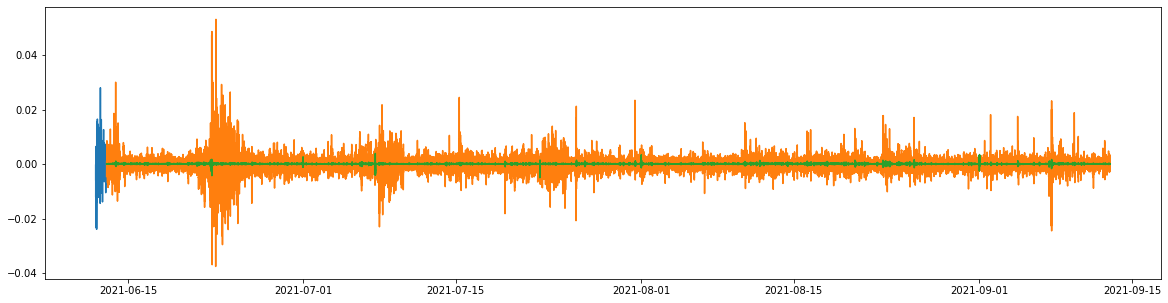

In [63]:
plt.figure(figsize=(20, 5))
TRAIN_M = 60*24
plt.plot(train_data['time'].tail(TRAIN_M), train_data[TARGET].tail(TRAIN_M))
plt.plot(valid_data['time'], valid_data[TARGET])
plt.plot(valid_data['time'], valid_data['yhat'])

In [42]:
from metrics import compute_metrics

In [44]:
valid_data['Asset_Name'] = valid_data['Asset_Name'].ffill()

In [45]:
scores, corrs = compute_metrics(valid_data)

In [46]:
scores

theor_corr       0.010107
weighted_corr    0.001064
corr_min         0.010107
corr_max         0.010107
corr_std              NaN
dtype: float64